# Import Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

# 1. Load the training and testing datasets

In [2]:
# Replace 'path_to_training_data.csv' and 'path_to_test_data.csv' with actual file paths
train_df = pd.read_csv('/work/fraudTrain.csv')
test_df = pd.read_csv('/work/fraudTest.csv')

In [3]:
# View basic information about both datasets
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [4]:
# Check for missing values in both datasets
train_missing_values = train_df.isnull().sum()
print("Missing values in training data:\n", train_missing_values)

Missing values in training data:
 Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64


In [5]:
# Descriptive statistics
print(train_df.describe())

         Unnamed: 0        cc_num           amt           zip           lat  \
count  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06   
mean   6.483370e+05  4.171920e+17  7.035104e+01  4.880067e+04  3.853762e+01   
std    3.743180e+05  1.308806e+18  1.603160e+02  2.689322e+04  5.075808e+00   
min    0.000000e+00  6.041621e+10  1.000000e+00  1.257000e+03  2.002710e+01   
25%    3.241685e+05  1.800429e+14  9.650000e+00  2.623700e+04  3.462050e+01   
50%    6.483370e+05  3.521417e+15  4.752000e+01  4.817400e+04  3.935430e+01   
75%    9.725055e+05  4.642255e+15  8.314000e+01  7.204200e+04  4.194040e+01   
max    1.296674e+06  4.992346e+18  2.894890e+04  9.978300e+04  6.669330e+01   

               long      city_pop     unix_time     merch_lat    merch_long  \
count  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06   
mean  -9.022634e+01  8.882444e+04  1.349244e+09  3.853734e+01 -9.022646e+01   
std    1.375908e+01  3.019564e+05  1.284128e+07  5.

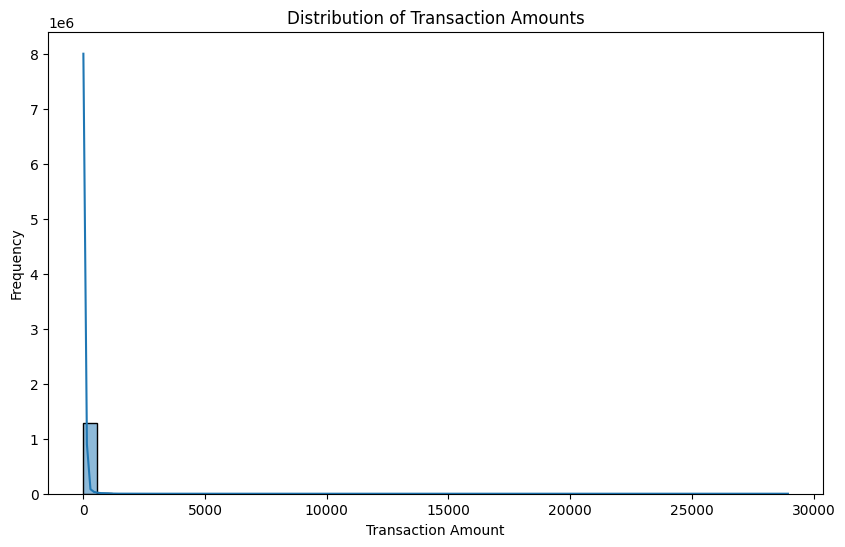

In [6]:
# Distribution of transaction amounts
plt.figure(figsize=(10,6))
sns.histplot(train_df['amt'], bins=50, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

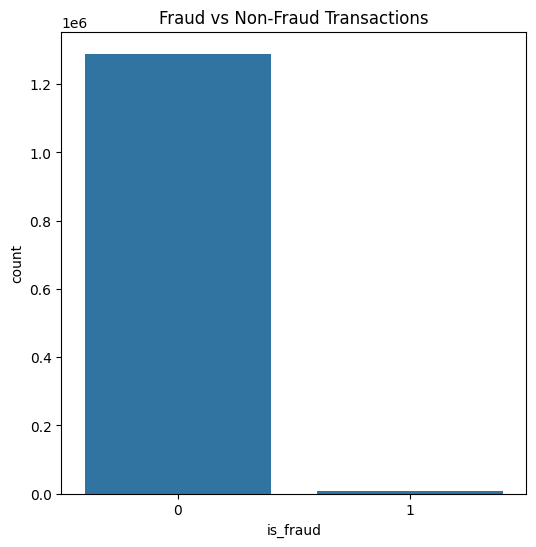

In [7]:
# Fraud vs Non-Fraud transactions
plt.figure(figsize=(6,6))
sns.countplot(x='is_fraud', data=train_df)
plt.title('Fraud vs Non-Fraud Transactions')
plt.show()

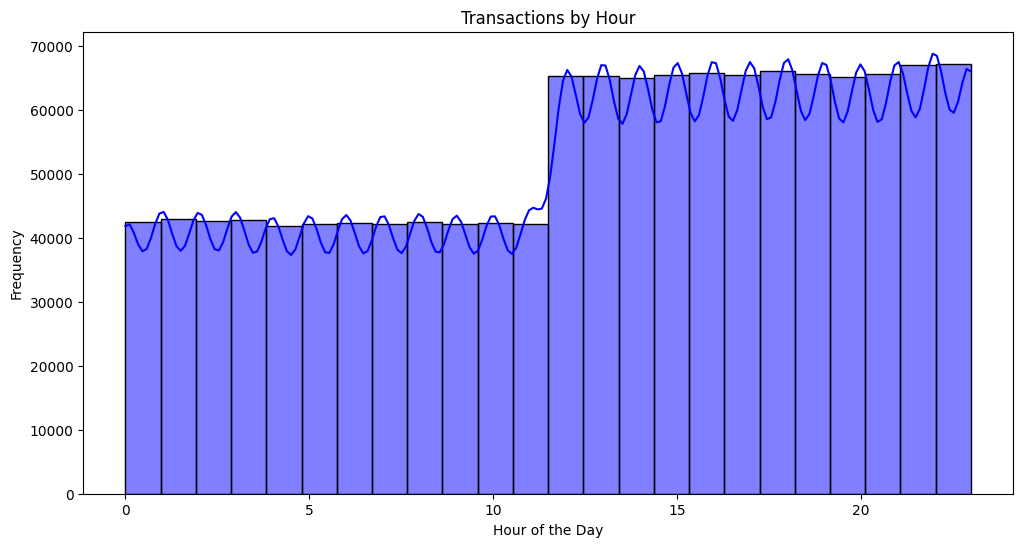

In [8]:
# Time-based patterns (Day/Hour)

df = train_df
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['hour'] = df['trans_date_trans_time'].dt.hour
df['day'] = df['trans_date_trans_time'].dt.day

plt.figure(figsize=(12,6))
sns.histplot(df['hour'], bins=24, kde=True, color='blue')
plt.title('Transactions by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.show()

# 2. Data Preprocessing for both training and testing datasets

In [9]:
# Drop unnecessary columns
train_df.drop(['trans_date_trans_time', 'first', 'last', 'street', 'city', 'state', 'zip', 'job', 'dob', 'trans_num'], axis=1, inplace=True)
test_df.drop(['trans_date_trans_time', 'first', 'last', 'street', 'city', 'state', 'zip', 'job', 'dob', 'trans_num'], axis=1, inplace=True)

# Convert categorical columns to numeric (One-Hot Encoding) for both training and testing sets
train_df = pd.get_dummies(train_df, columns=['category', 'gender', 'merchant'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['category', 'gender', 'merchant'], drop_first=True)

In [10]:
# Ensure both datasets have the same columns (in case one-hot encoding creates mismatched columns)
missing_cols = set(train_df.columns) - set(test_df.columns)
for col in missing_cols:
    test_df[col] = 0
test_df = test_df[train_df.columns]

# Handling missing values by imputing with mean (if any)
train_df.fillna(train_df.mean(), inplace=True)
test_df.fillna(test_df.mean(), inplace=True)

In [11]:
# Standardize the data
scaler = StandardScaler()
train_df[['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long']] = scaler.fit_transform(train_df[['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long']])
test_df[['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long']] = scaler.transform(test_df[['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long']])

# 3. Model Building

In [12]:
# Separate features and labels for training and testing data
X_train = train_df.drop('is_fraud', axis=1)
y_train = train_df['is_fraud']

X_test = test_df.drop('is_fraud', axis=1)
y_test = test_df['is_fraud']

In [13]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# 4. Evaluation and Conclusion

In [15]:
# Function to evaluate models
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_pred)
    
    print(f'{model_name} Performance:')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'AUC-ROC: {auc_roc:.4f}')
    print()

In [16]:
# Evaluate all models
evaluate_model(y_test, lr_pred, 'Logistic Regression')
evaluate_model(y_test, dt_pred, 'Decision Tree')
evaluate_model(y_test, rf_pred, 'Random Forest')
evaluate_model(y_test, gb_pred, 'Gradient Boosting')

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Logistic Regression Performance:
Accuracy: 0.9961
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
AUC-ROC: 0.5000

Decision Tree Performance:
Accuracy: 0.9912
Precision: 0.1268
Recall: 0.2172
F1 Score: 0.1601
AUC-ROC: 0.6057

Random Forest Performance:
Accuracy: 0.9971
Precision: 0.9778
Recall: 0.2466
F1 Score: 0.3939
AUC-ROC: 0.6233

Gradient Boosting Performance:
Accuracy: 0.9969
Precision: 0.5863
Recall: 0.7002
F1 Score: 0.6382
AUC-ROC: 0.8492



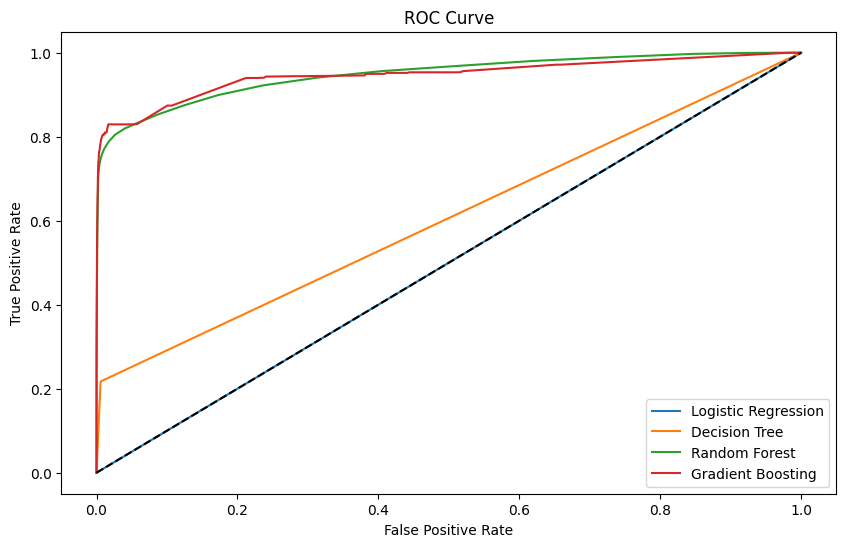

In [17]:
# Plot ROC Curve for all models
plt.figure(figsize=(10,6))
models = [('Logistic Regression', lr_model), ('Decision Tree', dt_model), ('Random Forest', rf_model), ('Gradient Boosting', gb_model)]
for name, model in models:
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

Based on the evaluation metrics, the Gradient Boosting model is the most suitable for detecting fraudulent transactions. Although the Random Forest and Logistic Regression models show high accuracy (0.9971 and 0.9961, respectively), accuracy alone is not sufficient for fraud detection due to the class imbalance problem (many more non-fraudulent transactions than fraudulent ones). The Gradient Boosting model demonstrates a much better balance between precision (0.5863) and recall (0.7002), resulting in a higher F1 score (0.6382), which reflects its ability to effectively identify fraudulent transactions while minimizing false positives. Moreover, its AUC-ROC score (0.8492) indicates that the model has a strong ability to distinguish between fraudulent and non-fraudulent transactions. In contrast, the Logistic Regression model fails to capture fraudulent transactions, as shown by its zero recall and precision. While the Random Forest has good precision, its low recall (0.2466) indicates it misses many fraudulent cases. Gradient Boosting strikes the best balance for this problem, making it the most reliable model for fraud detection.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=47cb13f9-e402-40de-9ec6-9496729eb9dc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>